## Birthday Paradox

It still feels unbelievable that with 100 people that 99.99+% probability that 2 share the same birthday! 

**Let's do some random sampling and see. Then see how the theory compares.**

In [1]:
import random

def random_birthday():
	return random.randint(1, 365)

In [31]:
def simulate_room_shared(N=100):
	birthdays = set()
	for _ in range(N):
		bday = random_birthday()
		if bday in birthdays:
			return True
		birthdays.add(bday)
	return False

simulate_room_shared(100)	

True

What about 23 which should have a 50% chance at least one pair of people share a birthday?

Text(0.5, 0, 'number of people in room')

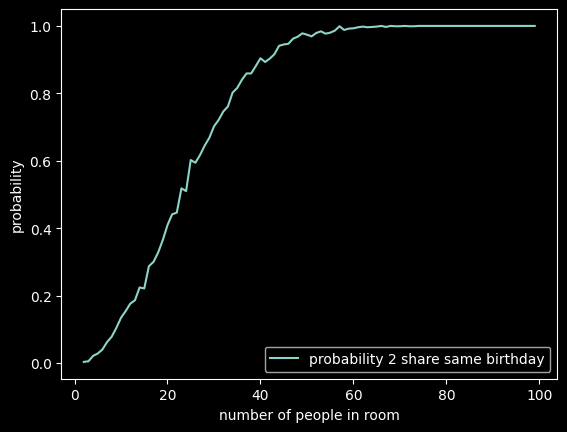

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

def estimate_prob(N, trials=1_000):
	results = [int(simulate_room_shared(N)) for _ in range(trials)]
	return sum(results) / trials

r = range(2,100)
plt.plot(r,[estimate_prob(i) for i in r], label="probability 2 share same birthday")
plt.legend()
plt.ylabel("probability")
plt.xlabel("number of people in room")

### Average number of people that have at least another who shares the same birthday

Before I show this theoretically, what about generally speaking how many share a birthday?

100%|██████████| 50/50 [00:02<00:00, 20.79it/s]


Text(0.5, 0, 'number of people in room')

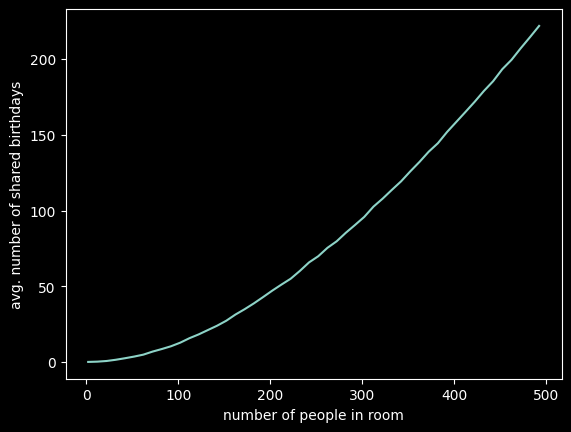

In [62]:
from tqdm import tqdm

def count_raw_shared_birthdays(N):
	shared = 0
	birthdays = set()
	for i in range(N):
		bday = random_birthday()
		if bday in birthdays:
			shared += 1
		birthdays.add(bday)
	return shared

def count_average_trials(N, trials=200):
	summed = 0
	for _ in range(trials):
		summed += count_raw_shared_birthdays(N)
	return summed / trials

r = range(2, 500, 10)
sim = [count_average_trials(i) for i in tqdm(r)]
plt.plot(r, sim)
plt.ylabel("avg. number of shared birthdays")
plt.xlabel("number of people in room")

### 3 share
What about the chance that 3 share the exact same birthday? How does it differ?
What about 4 and so on?

100%|██████████| 298/298 [00:10<00:00, 28.06it/s]


Text(0.5, 0, 'number of people in room')

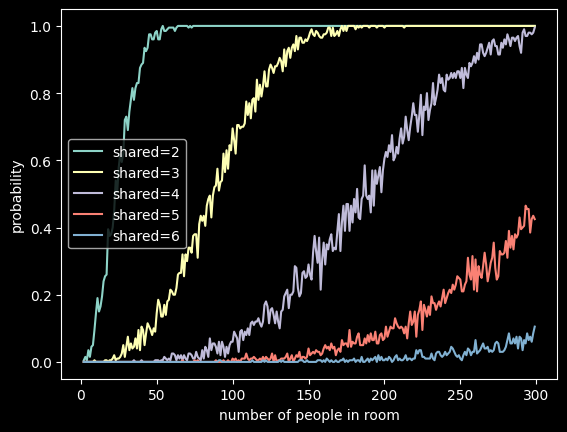

In [109]:
def count_bdays_random(N=100):
    birthdays = [0 for _ in range(365)]
    for _ in range(N):
        bday = random_birthday()
        birthdays[bday-1] += 1
    return birthdays

def any_shared(bdays, shared=2):
    return any([b >= shared for b in bdays]) 

def trials_n_shared(N, shared=2, trials=200):
    summed = 0
    for _ in range(trials):
        if any_shared(count_bdays_random(N), shared):
            summed += 1
    return summed/trials

r = range(2, 300)
shared = 6
for s in range(2, shared+1):
    plt.plot(r, [trials_n_shared(i, s) for i in tqdm(r)], label=f"shared={s}")
plt.legend()
plt.ylabel("probability")
plt.xlabel("number of people in room")

So there really is something magic about 2 people having shared. Since as you increase the number of the same shared birthday, the probability drops off greatly.

What is really cool is that for 300 people that is a near 100% chance that there is atleast one instance where 4 people all share the exact same birthday!

Which sort of bring of the interesting point: What is the min number of people in a room such that the given number of shared people on one birthday is 100% certain.

For example:

In [139]:
print(f"{trials_n_shared(80, shared=2)=}")
print(f"{trials_n_shared(200, shared=3)=}")
print(f"{trials_n_shared(350, shared=4)=}")
print(f"{trials_n_shared(550, shared=5)=}")
# ...?

trials_n_shared(80, shared=2)=1.0
trials_n_shared(200, shared=3)=1.0
trials_n_shared(350, shared=4)=1.0
trials_n_shared(550, shared=5)=1.0


Can I come up with a function that given the number shared $s$ returns the minimum number of people in a room that approaches 1.0 prob?

Theoretically probably more difficult so I'll just use my simulation code:

In [204]:
def min_room_per_n_shared(error_threshold=1e-3, n_shared=2, trials=100, min_n_room=0, skip=1):
	n_room = min_n_room
	while True: 
		prob = trials_n_shared(n_room, n_shared, trials)
		if (prob + error_threshold) >= 1.0:
			return n_room
		n_room += skip
		
print("min number of people to be certain 2 share:", min_room_per_n_shared(n_shared=2))

min number of people to be certain 2 share: 55


In [324]:
minN = []
skip = 1
shared = 100
shared_range = range(2, shared+1, 2)
for i in tqdm(shared_range):
	mini = min_room_per_n_shared(n_shared=i, min_n_room=minN[-1] if len(minN) > 0 else 2, skip=skip)
	skip += 25
	minN.append(mini)

100%|██████████| 50/50 [01:59<00:00,  2.39s/it]


Text(0.5, 0, 'n_shared')

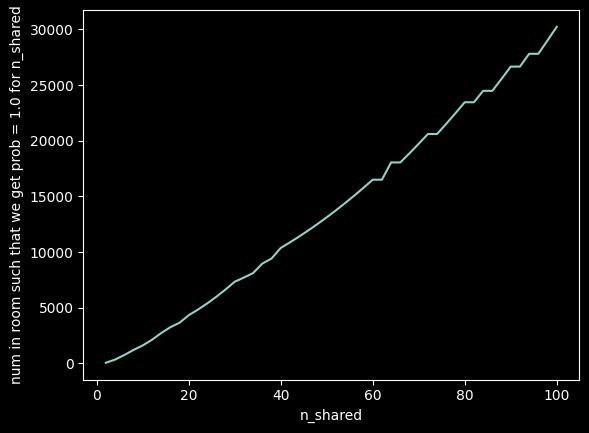

In [325]:
plt.plot(shared_range, minN)
plt.ylabel("num in room such that we get prob = 1.0 for n_shared")
plt.xlabel("n_shared")

In [331]:
from scipy import odr
data = odr.Data(shared_range, minN)
odr_obj = odr.ODR(data, odr.quadratic)
output = odr_obj.run()
t = lambda x: output.beta[0]*x**2 + output.beta[1]*x + output.beta[2]

array([ 5.56085695e-01,  2.52400907e+02, -8.55823510e+02])

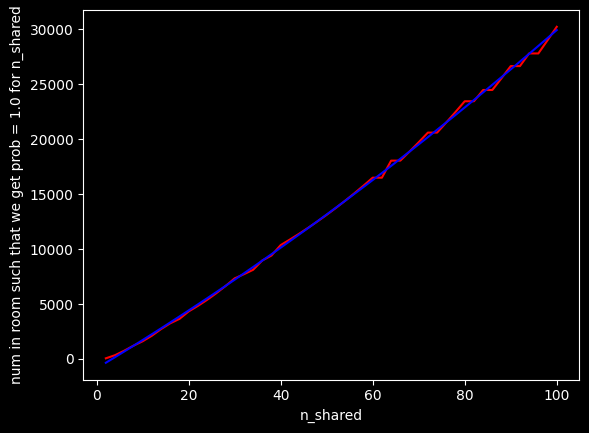

In [342]:
plt.plot(shared_range, minN, c="red")
plt.plot(shared_range, [t(x) for x in shared_range], c="blue")
plt.ylabel("num in room such that we get prob = 1.0 for n_shared")
plt.xlabel("n_shared")
output.beta